<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/kalman-filters/rlabbe/rlabbe_04_1d_kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math

import numpy as np

from scipy.stats import norm

from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

from ipywidgets import fixed, interact
import ipywidgets as widgets

In [17]:
class Gaussian:
  def __init__(self, mean, var, name):
    self.mean = mean
    self.var = var
    self.name = name

    self.rv = norm(mean, var)

  def add(self, other, name):
    return Gaussian(self.mean + other.mean, self.var +other.var, name)

  def multiply(self, other, name):
    mean = (self.var * other.mean + other.var * self.mean) / (self.var + other.var)
    variance = (self.var * other.var) / (self.var + other.var)
    return Gaussian(mean, variance, name)

  def min_plot_value(self):
    return self.mean - 1.5 * self.var

  def max_plot_value(self):
    return self.mean + 1.5 * self.var

  def print(self):
    print('%s: Gaussian(%.2f, %.2f)' % (self.name, self.mean, self.var))

  def pdf(self, xs):
    return self.rv.pdf(xs)


In [4]:
def data_and_noise(x0 = 0, v = 2, a = 0, std = 1, count = 30, seed = 123):
  np.random.seed(seed)

  xs = np.array([x0 + t * v + 0.5 * a * t ** 2 for t in range(count)])
  noise = np.array(np.random.normal(0, std, count))
  return (xs, xs + noise)

In [18]:
def show_sum(mean1, var1, name1, mean2, var2, name2):
  one = Gaussian(mean1, var1, name1)
  two = Gaussian(mean2, var2, name2)

  sum_name = '%s + %s' % (name1, name2)
  sum = one.add(two, sum_name)

  min_point = min(one.min_plot_value(), two.min_plot_value(), sum.min_plot_value())
  max_point = max(one.max_plot_value(), two.max_plot_value(), sum.max_plot_value())

  points = np.arange(min_point, max_point, 0.1)
  plot(points, one.pdf(points), label=name1)
  plot(points, two.pdf(points), label=name2)
  plot(points, sum.pdf(points), label=sum_name)

  plt.legend()
  plt.show()


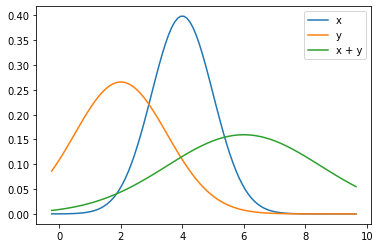

In [19]:
show_sum(4, 1, 'x', 2, 1.5, 'y')